In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import shutil
import sys
import json

# Download the dataset

In [6]:
def get_mnist():
    # The code to download the mnist data original came from
    # https://cntk.ai/pythondocs/CNTK_103A_MNIST_DataLoader.html
    
    import gzip
    import numpy as np
    import os
    import struct

    try: 
        from urllib.request import urlretrieve 
    except ImportError: 
        from urllib import urlretrieve

    def load_data(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x3080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))[0]
                if n != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} entries.".format(num_samples)
                    )
                crow = struct.unpack(">I", gz.read(4))[0]
                ccol = struct.unpack(">I", gz.read(4))[0]
                if crow != 28 or ccol != 28:
                    raise Exception(
                        "Invalid file: expected 28 rows/cols per image."
                    )
                # Read data.
                res = np.frombuffer(
                    gz.read(num_samples * crow * ccol), dtype=np.uint8
                )
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples, crow, ccol)) / 256


    def load_labels(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x1080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))
                if n[0] != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} rows.".format(num_samples)
                    )
                # Read labels.
                res = np.frombuffer(gz.read(num_samples), dtype=np.uint8)
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples))


    def try_download(data_source, label_source, num_samples):
        data = load_data(data_source, num_samples)
        labels = load_labels(label_source, num_samples)
        return data, labels
    
    
    # Not sure why, but yann lecun's website does no longer support 
    # simple downloader. (e.g. urlretrieve and wget fail, while curl work)
    # Since not everyone has linux, use a mirror from uni server.
    #     server = 'http://yann.lecun.com/exdb/mnist'
    server = 'https://raw.githubusercontent.com/fgnt/mnist/master'
    
    # URLs for the train image and label data
    url_train_image = f'{server}/train-images-idx3-ubyte.gz'
    url_train_labels = f'{server}/train-labels-idx1-ubyte.gz'
    num_train_samples = 60000

    print("Downloading train data")
    train_features, train_labels = try_download(url_train_image, url_train_labels, num_train_samples)

    # URLs for the test image and label data
    url_test_image = f'{server}/t10k-images-idx3-ubyte.gz'
    url_test_labels = f'{server}/t10k-labels-idx1-ubyte.gz'
    num_test_samples = 10000

    print("Downloading test data")
    test_features, test_labels = try_download(url_test_image, url_test_labels, num_test_samples)
    
    return train_features, train_labels, test_features, test_labels

In [7]:
train_features, train_labels, test_features, test_labels = get_mnist()

Done.
Done.
Done.
Done.


In [8]:
from scipy.ndimage.interpolation import shift
from tqdm import tqdm 

class ImgGenerator:
    def __init__(self, orig_img, orig_label):
        self.orig_img = orig_img
        self.orig_label = orig_label
        self.generated_imgs = []
        self.labels = []
        
    def shift_image(self,img, x,y):
        shifted_img = shift(img,[x,y])
        return shifted_img
    
    
    def generate_im(self, shift_x, shift_y):
        pb = tqdm(total=len(self.orig_label))
        for img, label in zip(self.orig_img, self.orig_label):
            right_shift = self.shift_image(img, 0, shift_x)#.reshape(-1,28*28)
            left_shift  = self.shift_image(img, 0, -shift_x)#.reshape(-1,28*28)
            up_shift = self.shift_image(img, shift_y,0)#.reshape(-1,28*28)
            down_shift = self.shift_image(img, -shift_y,0)#.reshape(-1,28*28)
            self.generated_imgs.extend([img, right_shift, left_shift, up_shift, down_shift])
            self.labels.extend([label]*5)
            pb.update(1)
        return self.generated_imgs, self.labels
    

In [9]:
# #use the generated images to train the ANN
# p = ImgGenerator(train_features, train_labels)
# gen_img, gl = p.generate_im(2,2)


Label: 9


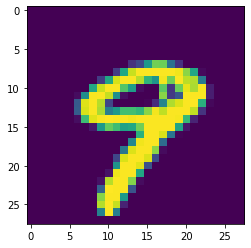

In [10]:
plt.imshow(test_features[9])
print('Label: {}'.format(test_labels[9]))

In [11]:
def validation_split(x, y, frac):
    lx = len(x)
    print(lx*frac)
    p = np.random.permutation(len(x))
    
    return x[p[:int(lx*frac)]], y[p[:int(lx*frac)]], x[p[int(lx*frac):]], y[p[int(lx*frac):]]
    

## Remember:
> With reshape you can stack all pixels in a big vector that can be used as NN input

In [12]:
train_features1 = train_features.reshape(-1, 28*28)
test_features1 = test_features.reshape(-1, 28*28)
print(train_features1.shape, train_labels.shape)
#x_val, y_val, train_features1, train_labels = validation_split(train_features1, train_labels, 0.1)

#gen_img = np.array(gen_img)
#gen_img1 = gen_img.reshape(-1,28*28)


(60000, 784) (60000,)


In [13]:
class Variable:
    def __init__(self, value, operation):
        self.value = np.array(value)
        self.operation = operation
        
    
#     def backprop(self):
#         # We define the backpropagation code later.
#         return backprop(self)
    
class Parameter(Variable):
    """
    This class should be used for Variables that are learnable.
    You can later use this class to distinguish learnable variables
    from other variables (`isinstance(variable, Parameter)`).
    """
    def __init__(self, value):
        super().__init__(value, operation=None)
        self.gradient = np.zeros_like(self.value)
        
class Input(Variable):
    """
    This class should be used as wrapper for inputs that are not learnable.
    """
    def __init__(self, value):
        super().__init__(value, operation=None)
        

class Layer:
    def __init__(self):
        self.parameters = []
    
    def forward(self, X):
        raise NotImplementedError
        
    def backward(self,D):
        raise NotImplementedError
        
    def add_param(self, values):
        param = Parameter(values)
        self.parameters.append(param)
        return param
    
    def update_parameters(self, optimizer):
        for param in self.parameters:
            optimizer.update(param)
        

class AffineLayer(Layer):
    def __init__(self, in_units, out_units):
        super().__init__()
        small_value = 0.01
        weight_vals = np.random.uniform(
                    size=[in_units, out_units],
                    low=-small_value,
                    high=small_value
                    )
        self.W = self.add_param(weight_vals)
        self.b = self.add_param(np.zeros(shape=out_units))
        
    def forward(self, X):
        def backward(D):
            #print(self.__class__.__name__)
            
            self.W.gradient = self.W.gradient + X.T @ D  
                                  ## todo to check for correctness (is += required)
            self.b.gradient = self.b.gradient + np.sum(D,axis=0) 
           
            return D @ self.W.value.T
       
       
        return X @ self.W.value + self.b.value, backward
    
    
class Sequential(Layer):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        for layer in layers:
            self.parameters.extend(layer.parameters) 
        
    def forward(self, X):
        backprops = []
        op = X
        for layer in self.layers:
            op, backprop = layer.forward(op)
            backprops.append(backprop)

        def backward(D):
            for backprop in reversed(backprops):
                D = backprop(D)
            return D
        return op , backward

In [14]:
class ReLU(Layer):
    def forward(self, X):
        mask = X > 0
        return X * mask, lambda D: D * mask
        
    
    
class Sigmoid(Layer):
    def forward(self, X):
        op = 1/(1+np.exp(-X))
        
        def backward(D):
            return D #* op * (1 - op)
        
        return op, backward
    
class SGDOptimizer():
    def __init__(self, lr=0.1):
        self.lr = lr

    def update(self, param):
        param.value = param.value - self.lr * param.gradient 
        param.gradient.fill(0)

In [15]:
def cross_entropy(predictions, targets, epsilon=1e-11):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions))/N
    return ce , predictions - targets   #todo verify derivative of ce loss



def mse_loss(Y_, Y):
    diff = Y_ - Y.reshape(Y_.shape)
    return np.square(diff).mean(), 2 * diff / len(diff)

    

def one_hot_encoder(x_label):
    rows = x_label.shape[0]
    oh_x = np.zeros((rows, 10))
    for i in range(rows):
        oh_x[i][x_label[i]] = 1
    
    return oh_x

class Softmax(Layer):
    def forward(self,X):
        exps = np.exp(X - np.max(X))
        def backward(D):
            return D
        return exps / np.sum(exps), backward




In [16]:
# tgt = one_hot_encoder(np.array([3,5]))
# pred = np.random.rand(2,10)
# l,d = cross_entropy(pred,tgt)
# tgt*pred

# print (l)

In [34]:
from tqdm import tqdm

class DigitLearner():
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss = loss_fn
        self.optimizer = optimizer
        
    def fit_batch(self,X,Y):
        Y_, backward = self.model.forward(X)
          #softmax_crossentropy_with_logits
        
        L , D = self.loss(Y_, Y)           ## todo loss function derivative 
                                
     
        backward(D)
        self.model.update_parameters(self.optimizer)
        return L
  
    def fit(self, X, Y, epochs, bs):
        losses = []
        val_loss=[]
        pbar = tqdm(total=epochs)
        for epoch in range(epochs):
            p = np.random.permutation(len(X))
            L = 0
            VL = 0
            for i in range(0, len(X), bs):
                X_batch = X[p[i:i + bs]]
                Y_batch = Y[p[i:i + bs]]
                L += self.fit_batch(X_batch, Y_batch)
                
  
            losses.append(L)

            pbar.update(1)
        return losses
    
    def predict(self, xtest):
        ypred, _ = self.model.forward(xtest)
        return ypred.argmax(axis=-1)
    
    def accuracy(y_pred, y_test):
        return np.sum(y_pred == y_test)/y_pred.shape[0]
    
    def dump_params(self,filename):
        with open(filename, 'w') as fp:
            json.dump([p.value.tolist() for p in self.model.parameters],fp)
            print("weights written to file")
            
    def load_params(self, filename):
        with open(filename) as fp:
            loaded_params = json.load(fp)
        for p, p_value in zip(self.model.parameters, loaded_params):
            p.value = p_value
        print("Loaded given weights!!")
            
        
    

In [35]:
def dump_parameters(loss, file):
    variables = get_variables(J)
    parameters = [
        v 
        for v in variables
        if isinstance(v, Parameter)
    ]
    with open(file, 'w') as fp:
        json.dump([p.value.tolist() for p in parameters], fp)
    print('Wrote the parameters')
    print(parameters)
    print('to', file)

#dump_parameters(loss=J, file='parameters.json')


def load_parameters(loss, file):
    variables = get_variables(J)
    parameters = [
        v 
        for v in variables
        if isinstance(v, Parameter)
    ]
    with open(file) as fp:
        parameters_values = json.load(fp)
    for p, p_value in zip(parameters, parameters_values):
        print(p.value, p_value)
        p.value[...] = p_value
        
    print('Loaded the parameters')
    print(parameters)
    print('from', file)

In [46]:
hidden_neurons = 256
lrate = 0.01
epochs = 35
batch = 32
X = train_features1 #gen_img1
y = train_labels
Y = one_hot_encoder(train_labels)  # np.array(gl)  train_labels


X_test = test_features1
Y_test = test_labels

test = DigitLearner(
    Sequential(
        AffineLayer(784, hidden_neurons), 
        ReLU(), 
        AffineLayer(hidden_neurons, hidden_neurons),
        ReLU(),
        AffineLayer(hidden_neurons, 10),
        Sigmoid()        
    ), 
    cross_entropy, 
    SGDOptimizer(lr=lrate)
)

losses = test.fit(X, Y, epochs=epochs, bs=batch)







  0%|          | 0/35 [00:00<?, ?it/s]




  3%|▎         | 1/35 [00:04<02:25,  4.29s/it]




  6%|▌         | 2/35 [00:08<02:21,  4.28s/it]




  9%|▊         | 3/35 [00:12<02:16,  4.26s/it]




 11%|█▏        | 4/35 [00:17<02:11,  4.26s/it]




 14%|█▍        | 5/35 [00:21<02:07,  4.25s/it]




 17%|█▋        | 6/35 [00:25<02:03,  4.25s/it]




 20%|██        | 7/35 [00:29<01:58,  4.24s/it]




 23%|██▎       | 8/35 [00:33<01:54,  4.24s/it]




 26%|██▌       | 9/35 [00:38<01:50,  4.24s/it]




 29%|██▊       | 10/35 [00:42<01:45,  4.24s/it]




 31%|███▏      | 11/35 [00:46<01:41,  4.23s/it]




 34%|███▍      | 12/35 [00:50<01:37,  4.22s/it]




 37%|███▋      | 13/35 [00:55<01:33,  4.24s/it]




 40%|████      | 14/35 [00:59<01:29,  4.27s/it]




 43%|████▎     | 15/35 [01:05<01:34,  4.71s/it]




 46%|████▌     | 16/35 [01:09<01:26,  4.58s/it]




 49%|████▊     | 17/35 [01:13<01:20,  4.49s/it]




 51%|█████▏    | 18/35 [01:18<01:16,  4.49s/it]




 54%|█████▍    | 19/35 [0

In [48]:
# save weights to a json file
test.dump_params("wt.json")

weights written to file


In [49]:
#create a new empty model here to load weights
hidden_neurons = 256
lrate = 0.01

mt_model = DigitLearner(
    Sequential(
        AffineLayer(784, hidden_neurons), 
        ReLU(), 
        AffineLayer(hidden_neurons, hidden_neurons),
        ReLU(),
        AffineLayer(hidden_neurons, 10),
        Sigmoid()        
    ), 
    cross_entropy, 
    SGDOptimizer(lr=lrate)
)



In [43]:
# load weights from a saved json file in a new model
mt_model.load_params("wt.json")

Loaded given weights!!


In [45]:
# use the new empty model with weights loaded from json to make prediction
tacc = DigitLearner.accuracy(mt_model.predict(X_test), Y_test)
print(tacc)

0.9768


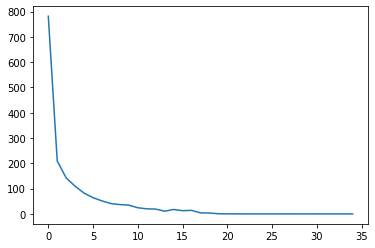

0.9855


In [47]:
#print(losses)
plt.plot(losses)

plt.show()
acc = DigitLearner.accuracy(test.predict(X_test), Y_test)

print(acc)

In [ ]:
pred = test.predict(X_test[:10])
print(pred, Y_test[:10])